## Job Fitment Prediction Model

## 1: Setup & Imports

In [1]:
# Setup & Imports
!pip install kaggle --quiet

import pandas as pd
import numpy as np
import re
import nltk
from google.colab import files

from sklearn.preprocessing       import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise      import cosine_similarity
from sklearn.model_selection       import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model          import LogisticRegression
from sklearn.ensemble               import RandomForestClassifier
from sklearn.metrics                import classification_report, average_precision_score, ndcg_score

from scipy import sparse
from sklearn.cluster    import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# NLTK downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## 2: Data Loading & Basic Cleanup

In [10]:
files.upload()  # upload your kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# download & unzip
!mkdir -p /content/data
!kaggle datasets download -d ravindrasinghrana/job-description-dataset -p /content/data
!unzip -q /content/data/job-description-dataset.zip -d /content/data

# Load a data and inspect
df = pd.read_csv('/content/data/job_descriptions.csv', nrows=100000)
df.info()
print("Shape:", df.shape)
print("Missing per column:\n", df.isnull().mean().sort_values(ascending=False).head(10))
print("Duplicates:", df.duplicated(subset=['Job Id']).sum())

# Drop duplicates & missing critical text
df.drop_duplicates(subset='Job Id', inplace=True)
df.dropna(subset=['Job Title','Job Description'], inplace=True)

# Impute Company Profile NaNs with empty string
print("Before imputation, nulls in Company Profile:", df['Company Profile'].isnull().sum())
df.fillna({'Company Profile': ''}, inplace=True)
print("After imputation, nulls in Company Profile:", df['Company Profile'].isnull().sum())

# Fill small missing Company Profile
df.fillna({'Company Profile': ''}, inplace=True)

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/ravindrasinghrana/job-description-dataset
License(s): CC0-1.0
job-description-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/data/job_descriptions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Job Id            100000 non-null  int64  
 1   Experience        100000 non-null  object 
 2   Qualifications    100000 non-null  object 
 3   Salary Range      100000 non-null  object 
 4   location          100000 non-null  object 
 5   Country           100000 non-null  object 
 6   latitude          100000 non-null  float64
 7   longitude         100000 non-null  float64
 8   Work Type         100000 non-null  object 
 9   Company Size     

## 3: Feature Engineering

In [12]:
## Numeric Experience
def parse_experience(x):
    nums = re.findall(r'\d+', str(x))
    if len(nums)>=2:
        return (int(nums[0])+int(nums[1]))/2
    elif len(nums)==1:
        return int(nums[0])
    else:
        return np.nan

df['Experience_num'] = df['Experience'].apply(parse_experience)
df['Experience_num'].fillna(df['Experience_num'].median(), inplace=True)

print("Experience_num statistics:")
print(df['Experience_num'].describe(), "\n")
print("Sample Experience → Experience_num mappings:")
print(df[['Experience','Experience_num']].head(), "\n")

# Text Cleaning
from nltk.corpus import stopwords
from nltk.stem       import WordNetLemmatizer

stop = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def clean_text(txt):
    txt = re.sub(r'[^a-z0-9\s]', ' ', str(txt).lower())
    tokens = nltk.word_tokenize(txt)
    return " ".join(lemm.lemmatize(t) for t in tokens if t not in stop and len(t)>2)

df['text_features'] = (
    df['Job Description'].apply(clean_text) + " " +
    df['skills'].apply(clean_text) + " " +
    df['Responsibilities'].apply(clean_text)
)

print("Sample cleaned text_features:")
for i, txt in df['text_features'].head(3).items():
    print(f"- {txt[:100]}…")
print()

## Multi-Label Binarization
mlb_s = MultiLabelBinarizer()
mlb_b = MultiLabelBinarizer()

df['skills_list']   = df['skills'].str.split(r',\s*')
df['benefits_list'] = df['Benefits'].str.split(r',\s*')

skills_bin   = pd.DataFrame( mlb_s.fit_transform(df['skills_list']),
    columns=[f"skill_{c}" for c in mlb_s.classes_], index=df.index)
benefits_bin = pd.DataFrame( mlb_b.fit_transform(df['benefits_list']),
    columns=[f"benefit_{c}" for c in mlb_b.classes_], index=df.index)

df = pd.concat([df, skills_bin, benefits_bin], axis=1)

print("Skills binary matrix shape:", skills_bin.shape)
print("Benefits binary matrix shape:", benefits_bin.shape)
print("First 5 skill columns:", skills_bin.columns[:5].tolist())
print("First 5 benefit columns:", benefits_bin.columns[:5].tolist(), "\n")

## One-Hot Categoricals
# Role
top_roles = df['Role'].value_counts().nlargest(10).index
df['Role_top'] = df['Role'].where(df['Role'].isin(top_roles), 'Other')
role_dum = pd.get_dummies(df['Role_top'], prefix='Role')

# Work Type
work_dum = pd.get_dummies(df['Work Type'], prefix='WorkType')

# Location
top_locs = df['location'].value_counts().nlargest(20).index
df['loc_top'] = df['location'].where(df['location'].isin(top_locs), 'OtherLoc')
loc_dum = pd.get_dummies(df['loc_top'], prefix='Loc')

# Qualifications
top_quals = df['Qualifications'].value_counts().nlargest(20).index
df['Qual_top'] = df['Qualifications'].where(df['Qualifications'].isin(top_quals), 'OtherQual')
qual_dum = pd.get_dummies(df['Qual_top'], prefix='Qual')

# Merge all
df = pd.concat([df, role_dum, work_dum, loc_dum, qual_dum], axis=1)

print("Role dummies shape:", role_dum.shape)
print("WorkType dummies shape:", work_dum.shape)
print("Location dummies shape:", loc_dum.shape)
print("Qualification dummies shape:", qual_dum.shape)
print("Sample one-hot columns:")
print("  Roles:", role_dum.columns[:5].tolist())
print("  WorkType:", work_dum.columns[:3].tolist())
print("  Location:", loc_dum.columns[:3].tolist())
print("  Quals:", qual_dum.columns[:3].tolist())

<ipython-input-12-946c26cb1681>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Experience_num'].fillna(df['Experience_num'].median(), inplace=True)


Experience_num statistics:
count    100000.000000
mean          7.007255
std           1.430037
min           4.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          10.000000
Name: Experience_num, dtype: float64 

Sample Experience → Experience_num mappings:
      Experience  Experience_num
0  5 to 15 Years            10.0
1  2 to 12 Years             7.0
2  0 to 12 Years             6.0
3  4 to 11 Years             7.5
4  1 to 12 Years             6.5 

Sample cleaned text_features:
- social medium manager oversee organization social medium presence create schedule content engage fol…
- frontend web developer design implement user interface website ensuring visually appealing user frie…
- quality control manager establish enforce quality standard within organization develop quality contr…

Skills binary matrix shape: (100000, 542)
Benefits binary matrix shape: (100000, 43)
First 5 skill columns: ['skill_API design and development RESTful API knowled

## 4: Vectorization & Feature Matrix

In [14]:
# Text TF-IDF
tfidf_desc = TfidfVectorizer(max_features=5000, stop_words='english')
X_desc     = tfidf_desc.fit_transform(df['text_features'])
print("X_desc shape:", X_desc.shape)

tfidf_comp = TfidfVectorizer(max_features=1000, stop_words='english')
X_comp     = tfidf_comp.fit_transform(df['Company Profile'])
print("X_comp shape:", X_comp.shape)

# Numeric & one-hot to sparse
X_exp    = sparse.csr_matrix(df['Experience_num'].values.reshape(-1,1))
print("X_exp shape:", X_exp.shape)
X_role   = sparse.csr_matrix(role_dum.values)
print("X_role shape:", X_role.shape)
X_work   = sparse.csr_matrix(work_dum.values)
print("X_work shape:", X_work.shape)
X_loc    = sparse.csr_matrix(loc_dum.values)
print("X_loc shape:", X_loc.shape)
X_qual   = sparse.csr_matrix(qual_dum.values)
print("X_qual shape:", X_qual.shape)
X_skills = sparse.csr_matrix(skills_bin.values)
print("X_skills shape:", X_skills.shape)
X_benef  = sparse.csr_matrix(benefits_bin.values)
print("X_benef shape:", X_benef.shape)

# Combine
X = sparse.hstack([
    X_desc, X_comp, X_exp,
    X_role, X_work, X_loc, X_qual,
    X_skills, X_benef
], format='csr')
print("Combined feature matrix X shape:", X.shape)

# Synthetic labels
cand_prof = "python data analysis machine learning sql"
cand_vec  = tfidf_desc.transform([cand_prof])
sim       = cosine_similarity(X_desc, cand_vec).flatten()
df['fit'] = (sim > 0.20).astype(int)
y         = df['fit'].values
print("Synthetic fit distribution:\n", df['fit'].value_counts())

X_desc shape: (100000, 1914)
X_comp shape: (100000, 1000)
X_exp shape: (100000, 1)
X_role shape: (100000, 11)
X_work shape: (100000, 5)
X_loc shape: (100000, 21)
X_qual shape: (100000, 10)
X_skills shape: (100000, 542)
X_benef shape: (100000, 43)
Combined feature matrix X shape: (100000, 3547)
Synthetic fit distribution:
 fit
0    97677
1     2323
Name: count, dtype: int64


## 5: Train/Test Split & CV Setup

In [15]:
# 80 - Train, 20 - Test data
y = df['fit'].values  # ensure in memory
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:\n", pd.Series(y_train).value_counts(normalize=True))
print("Test class distribution:\n", pd.Series(y_test).value_counts(normalize=True))

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Initialized StratifiedKFold with 5 splits")

Train shape: (80000, 3547) Test shape: (20000, 3547)
Train class distribution:
 0    0.976775
1    0.023225
Name: proportion, dtype: float64
Test class distribution:
 0    0.97675
1    0.02325
Name: proportion, dtype: float64
Initialized StratifiedKFold with 5 splits


## 6: Content-Based Evaluation

In [16]:
# Top-N Accuracy
def top_n_acc(y_true, scores, N):
    idx = np.argsort(scores)[-N:][::-1]
    return (y_true[idx].sum() > 0).astype(int)

print("Top-1 Acc:", top_n_acc(y, sim, 1))
print("Top-5 Acc:", top_n_acc(y, sim, 5))
print("Top-10 Acc:", top_n_acc(y, sim, 10))

# MAP & NDCG
print("MAP:", average_precision_score(y, sim))
print("NDCG:", ndcg_score([y], [sim]))


Top-1 Acc: 1
Top-5 Acc: 1
Top-10 Acc: 1
MAP: 0.9999999999999999
NDCG: 0.9999999999999989


## 7: Supervised Models & Metrics

In [7]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))

# 5-Fold CV F1
print("LR CV F1:", cross_val_score(lr, X, y, cv=kf, scoring='f1').mean())
print("RF CV F1:", cross_val_score(rf, X, y, cv=kf, scoring='f1').mean())


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19535
           1       1.00      1.00      1.00       465

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19535
           1       1.00      1.00      1.00       465

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

LR CV F1: 1.0
RF CV F1: 1.0


## 8: Clustering & Visualization

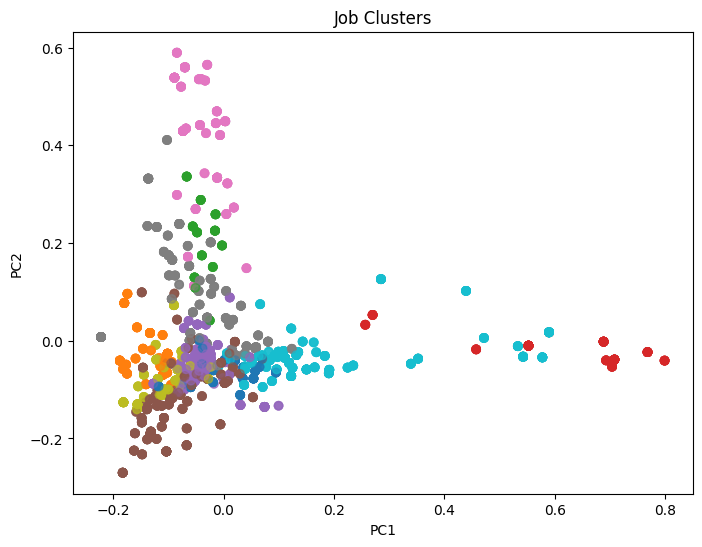

In [8]:
# kmeans clustering
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_desc)
df['cluster'] = kmeans.labels_

# PCA for plotting
idx = np.random.choice(X_desc.shape[0], 5000, replace=False)
X2 = PCA(2, random_state=42).fit_transform(X_desc[idx].toarray())
plt.figure(figsize=(8,6))
plt.scatter(X2[:,0], X2[:,1], c=df['cluster'].iloc[idx], alpha=0.5, cmap='tab10')
plt.title("Job Clusters"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()


## 9: Candidate Input & Outputs

In [9]:
# Input
candidate_input = input("Candidate profile: ")
cand_clean     = clean_text(candidate_input)
cand_vec       = tfidf_desc.transform([cand_clean])

# Content-Based Recommendations
scores = cosine_similarity(X_desc, cand_vec).flatten()
top_idx = np.argsort(scores)[-10:][::-1]
print("Top 10 Jobs:\n", df.iloc[top_idx][['Job Title','Company','location']])

# Fit flags
df['fit_flag'] = (scores > 0.20).astype(int)
print("Jobs flagged fit:", df['fit_flag'].sum())

# Cluster assignment
cand_cluster = kmeans.predict(cand_vec)[0]
print("Candidate assigned to cluster:", cand_cluster)

Candidate profile: Java, C++. 2 years experience
Top 10 Jobs:
             Job Title                   Company                   location
32775  Java Developer           Sonoco Products                     Harare
3714   Java Developer             General Mills                     Kigali
84085  Java Developer   Berkeley Group Holdings             Port-au-Prince
62946  Java Developer  Air Products & Chemicals                       Oslo
91237  Java Developer          Jacobs Solutions                      Praia
7321   Java Developer  Glenmark Pharmaceuticals                  Islamabad
84843  Java Developer   Sirius XM Holdings Inc.                 Willemstad
29919  Java Developer                       XPO  Sri Jayawardenepura Kotte
36510  Java Developer              Henry Schein                   Pristina
47048  Java Developer                      Nike  Kyiv (also known as Kiev)
Jobs flagged fit: 607
Candidate assigned to cluster: 9
